<h1>AD/PD project<span class="tocSkip"></span></h1>

<h3>Rui Benfeitas, Scilifelab, NBIS National Bioinformatics Infrastructure Sweden   </h3>
rui.benfeitas@scilifelab.se

In [1]:
## Preamble
import sklearn, leidenalg, itertools, random, re
import pandas as pd
import numpy as np
import igraph as ig
import sklearn.neighbors
import scipy as sp
from statsmodels.stats.multitest import multipletests
import gseapy as gp
import seaborn as sb
import pickle as pkl


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pickling
def pkl_save(filename, object_in):
    with open(filename, 'wb') as handle:
        pkl.dump(object_in, handle, protocol=pkl.HIGHEST_PROTOCOL)
        print('Saved file '+filename)
def pkl_load(filename):
    with open(filename, 'rb') as handle:
        out = pkl.load(handle)
    return(out)

# Data preprocessing

In [226]:
hpa=pd.read_csv('../data/hpa.tsv', sep="\t", index_col=2)[['Gene']]
data=pd.read_csv('../data/combinedCounts_ADPD-only.tsv', sep="\t", index_col=0)
data.head()

,zhangZheng.GSM506039_expr.tsv,zhangZheng.GSM506040_expr.tsv,zhangZheng.GSM506041_expr.tsv,zhangZheng.GSM506042_expr.tsv,zhangZheng.GSM506043_expr.tsv,zhangZheng.GSM506044_expr.tsv,zhangZheng.GSM506045_expr.tsv,zhangZheng.GSM506046_expr.tsv,zhangZheng.GSM506048_expr.tsv,zhangZheng.GSM506059_expr.tsv,...,ROSMAP_blood_RNAseq.Sample_578.tsv,ROSMAP_blood_RNAseq.Sample_579.tsv,ROSMAP_blood_RNAseq.Sample_588.tsv,ROSMAP_blood_RNAseq.Sample_589.tsv,ROSMAP_blood_RNAseq.Sample_591.tsv,ROSMAP_blood_RNAseq.Sample_595.tsv,ROSMAP_blood_RNAseq.Sample_599.tsv,ROSMAP_blood_RNAseq.Sample_600.tsv,ROSMAP_blood_RNAseq.Sample_602.tsv,ROSMAP_blood_RNAseq.Sample_610.tsv
V1,,,,,,,,,,,,,,,,,,,,,
ENSG00000002919,0.659151,0.375551,1.161161,12.610911,-4.574936,11.627628,-0.711342,-2.253656,1.326751,1.781420,...,2.709384,2.709384,2.709384,2.709384,2.709384,2.709384,2.709384,2.716117,2.709384,2.709384
ENSG00000007255,3.508398,3.194679,3.690117,13.451161,-1.351820,15.001638,2.678068,0.648126,3.092037,3.688798,...,5.356596,5.558797,5.356596,5.976336,5.356596,6.095421,5.356596,5.356596,5.356596,6.221375
ENSG00000005486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.900805,24.543071,24.543071,24.906659,24.543071,24.543071,24.925707,24.607174,24.543071,24.818020
ENSG00000005238,3.760331,3.036224,3.586251,14.665837,-2.042642,14.521826,3.319345,1.016384,4.787363,4.087742,...,5.172770,5.179937,4.941916,5.775283,4.941916,5.588033,5.042821,5.180983,5.203197,5.364507
ENSG00000005108,5.075862,6.658226,5.851592,14.149797,1.673632,15.350570,5.627240,5.155429,7.409817,8.651457,...,8.061695,8.061697,8.061695,8.061714,8.061695,8.061695,8.061695,8.061695,8.061695,8.061695


In [227]:
meta=pd.read_csv('../data/metadata.tsv', sep="\t")
pro_meta=meta.copy()
pro_meta=pro_meta.loc[pro_meta.Colname.isin(data.columns)]

In [228]:
pro_meta.groupby(['Phenotype','Region1'])[['Sample','Individual']].agg('count')

Sample  Individual
Phenotype           Region1                    
Alzheimer's disease Blood       154         154
                    Brain       475         475
Parkinson's disease Brain        54          54

In [229]:
## We drop blood samples
pro_meta=pro_meta.loc[pro_meta.Region1!='Blood',]

pro_meta.groupby(['Phenotype','Region2','Sex'])[['Source','Sample']].agg('count')

Source  Sample
Phenotype           Region2         Sex                   
Alzheimer's disease Cerebral cortex Female     304     304
                                    Male       171     171
Parkinson's disease Basal ganglia   f           11      11
                                    m           15      15
                    Cerebral cortex f            6       6
                                    m            8       8

For AD we also randomly select 171 females so that we have equal number of male and female samples.

In [230]:
ad_f=pro_meta.loc[(pro_meta.Phenotype.str.contains('Alzheimer'))&(pro_meta.Sex=='Female'),][:171]
ad_m=pro_meta.loc[(pro_meta.Phenotype.str.contains('Alzheimer'))&(pro_meta.Sex=='Male'),]
pd_b=pro_meta.loc[(pro_meta.Phenotype.str.contains('Parkinson')),]

In [231]:
pro_meta=pd.concat([pd.concat([ad_f,ad_m]),pd_b])

In [232]:
pkl_save('../data/meta_pro.pkl',pro_meta)

Saved file ../data/meta_pro.pkl


In [233]:
pro_meta=pkl_load('../data/meta_pro.pkl')

Men and women have different ages, but we will not further examine this as they are all with a ~10 year difference.

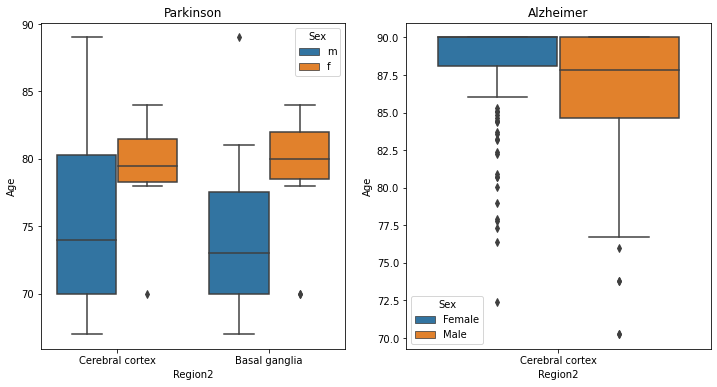

In [234]:
fig,ax=plt.subplots(ncols=2, figsize=(12,6))
ax=ax.flatten()

for vv in [0,1]:
    itype=['Parkinson','Alzheimer'][vv]
    sb.boxplot(
        data=pro_meta.loc[pro_meta.Phenotype.str.contains(itype)],
        x='Region2',  y='Age', hue='Sex', ax=ax[vv]
    )
    
    ax[vv].title.set_text(itype)

Dropping NAs

In [235]:
pro_data=data.copy()
pro_data=pro_data.loc[pro_data.isna().sum(1)==0,]
pro_data=pro_data.merge(hpa, left_index=True, right_index=True, how='left').loc[:,np.append(['Gene'],pro_data.columns)]

pro_data=pro_data.loc[:,np.append(['Gene'], pro_meta.Colname)]

In [236]:
pkl_save('../data/processed_gex.pkl',pro_data)

Saved file ../data/processed_gex.pkl


Because we have a substantially higher number of AD samples than PD, let's generate 2 networks instead of a single one that includes both groups. We will explore each network sepparately. Both networks will not be comparable quantitatively as their sizes are very different.

In [43]:
#setting gene names as index
pro_pd=pro_data.copy().set_index('Gene')
pro_pd=pro_pd.loc[:,pro_pd.columns.isin(np.append(['Gene'],pro_meta.loc[pro_meta.Phenotype.str.contains('Parkinson'),'Colname']))]

pro_ad=pro_data.copy().set_index('Gene')
pro_ad=pro_ad.loc[:,pro_ad.columns.isin(np.append(['Gene'],pro_meta.loc[pro_meta.Phenotype.str.contains('Alzheimer'),'Colname']))]


Checking expression values

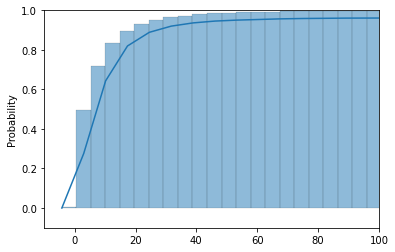

In [73]:
fig,ax=plt.subplots()
sb.histplot(
    pro_pd.mean(1), kde=True, cumulative=True, bins=300, stat='probability', ax=ax
)
ax.set(xlim=(-10,100), ylim=(-0.1,1));

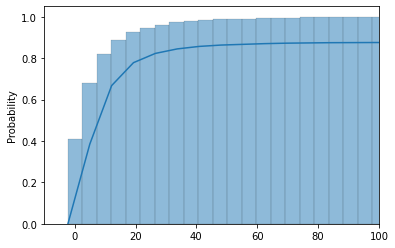

In [65]:
fig,ax=plt.subplots()
sb.histplot(
    pro_ad.mean(1), kde=True, cumulative=True, bins=300, stat='probability', ax=ax
)
ax.set(xlim=(-10,100));

We drop the bottom 15% lowly expressed genes.

In [105]:
pro_pd=pro_pd.loc[
    pro_pd.mean(1).sort_values().rank(pct=True).where(pro_pd.mean(1).sort_values().rank(pct=True)>0.15).dropna().index]

In [107]:
pro_ad=pro_ad.loc[
    pro_ad.mean(1).sort_values().rank(pct=True).where(pro_ad.mean(1).sort_values().rank(pct=True)>0.15).dropna().index]

Variance

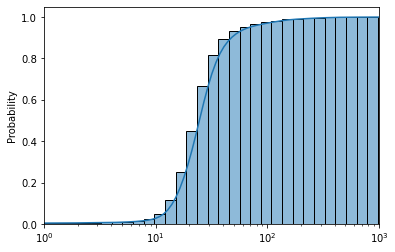

In [114]:
fig,ax=plt.subplots()
sb.histplot(
    pro_pd.var(1), kde=True, log_scale=True, cumulative=True, bins=75, stat='probability'
)
ax.set(xlim=(1,1000));

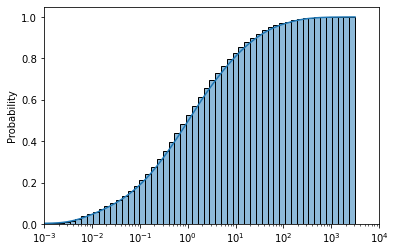

In [119]:
fig,ax=plt.subplots()
sb.histplot(
    pro_ad.var(1), kde=True, log_scale=True, cumulative=True, bins=75, stat='probability'
)
ax.set(xlim=(1e-3,1e4));

Dropping genes with variance in bottom 15%

In [3]:
pro_pd=pro_pd.loc[pro_pd.var(1).rank(pct=True).where(pro_pd.var(1).rank(pct=True)>0.15).dropna().index]
pro_ad=pro_ad.loc[pro_ad.var(1).rank(pct=True).where(pro_ad.var(1).rank(pct=True)>0.15).dropna().index]

Because we have a substantially higher number of AD samples than PD, let's generate 2 networks instead of a single one that includes both groups. We will explore each network sepparately. Both networks will not be comparable quantitatively as their sizes are very different.

In [4]:
pkl_save('../data/pro_pd_expression.pkl',pro_pd)
pkl_save('../data/pro_ad_expression.pkl',pro_ad)

Saved file ../data/pro_pd_expression.pkl
Saved file ../data/pro_ad_expression.pkl


# Association analysis

**PD**

In [5]:
def make_correlation(input_df):
    print('Computing correlations...')
    #Correlation and P val matrices
    Rmatrix, Pmatrix= sp.stats.spearmanr(input_df.T)
    Rmatrix=pd.DataFrame(Rmatrix, index=input_df.index.copy(), columns=input_df.index.copy())
    Pmatrix=pd.DataFrame(Pmatrix, index=input_df.index.copy(), columns=input_df.index.copy())

    print('Preparing to correct...')
    #prepare P matrix
    Psquared=Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(bool))
    Psquared.columns.name='Feat2'
    Pmatrix=Pmatrix.stack()
    Pmatrix.index.names=['v1','v2']
    Pmatrix=Pmatrix.reset_index()
    Pmatrix.columns=['feat1','feat2','P']
    
    #prepare R matrix
    Rmatrix=Rmatrix.where(np.triu(np.ones(Rmatrix.shape),1).astype(bool))
    Rmatrix.columns.name='Feat2'
    Rmatrix=Rmatrix.stack()
    Rmatrix.index.names=['v1','v2'] #Avoid stacked names colliding
    Rmatrix=Rmatrix.reset_index()
    Rmatrix.columns=['feat1','feat2','R']

    print('Joining triangular matrices...')
    # join both
    PRmatrix=pd.merge(Rmatrix.copy(), Pmatrix.copy(), on=['feat1','feat2']) 
    PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2].dropna()
    PRmatrix.reset_index(inplace=True,drop=True)
    
    print('Correcting P values (bonferroni)...')
    #Multiple hypothesis correction computed on the P column
    adjP=pd.DataFrame(multipletests(PRmatrix['P'], method='bonferroni')[1], columns=['Bonferroni'])

    print('Correcting P values (FDR)...')
    FDR=pd.DataFrame(multipletests(PRmatrix['P'], method='fdr_bh')[1], columns=['FDR'])
    
    PRmatrix=pd.concat([ PRmatrix, adjP], axis=1)
    PRmatrix=pd.concat([ PRmatrix, FDR], axis=1)
    
    # Imputing R where non significant
    print('Correcting R where FDR and Bonferroni are not significant...')
    PRmatrix.loc[:,'R (bonferroni)']=PRmatrix['R'].copy()
    PRmatrix.loc[:,'R (fdr)']=PRmatrix['R'].copy()
    PRmatrix.loc[PRmatrix['Bonferroni']>0.01,'R (bonferroni)']=0
    PRmatrix.loc[PRmatrix['FDR']>0.01,'R (fdr)']=0
    
    print('Done.')
    return(PRmatrix)

In [6]:
corr_pd=make_correlation(pro_pd)

Computing correlations...
Preparing to correct...
Joining triangular matrices...
Correcting P values (bonferroni)...
Correcting P values (FDR)...
Correcting R where FDR and Bonferroni are not significant...
Done.


In [7]:
corr_ad=make_correlation(pro_ad)

Computing correlations...
Preparing to correct...
Joining triangular matrices...
Correcting P values (bonferroni)...
Correcting P values (FDR)...
Correcting R where FDR and Bonferroni are not significant...
Done.


In [8]:
pkl_save('../data/corr_pd.pkl', corr_pd)
pkl_save('../data/corr_ad.pkl', corr_ad)

Saved file ../data/corr_pd.pkl
Saved file ../data/corr_ad.pkl


Number of statistically significant corrs:

In [10]:
print('PD')
for x in [(10**(-x)) for x in range(2,10)]:
    print('FDR<'+str(x)+':'+"\t"+str(corr_pd.loc[corr_pd.FDR<x,].shape[0]))

PD
FDR<0.01:	39183251
FDR<0.001:	38826293
FDR<0.0001:	38211314
FDR<1e-05:	37208188
FDR<1e-06:	35759717
FDR<1e-07:	33994120
FDR<1e-08:	32088665
FDR<1e-09:	30147025


In [9]:
print('AD')
for x in [(10**(-x)) for x in range(2,10)]:
    print('FDR<'+str(x)+':'+"\t"+str(corr_ad.loc[corr_ad.FDR<x,].shape[0]))

AD
FDR<0.01:	39363079
FDR<0.001:	39172479
FDR<0.0001:	38948148
FDR<1e-05:	38691139
FDR<1e-06:	38405951
FDR<1e-07:	38093600
FDR<1e-08:	37754911
FDR<1e-09:	37392006


Because we have too many correlations, we will select top 1% correlations for further analysis

In [11]:
corr_pd=corr_pd.sort_values('FDR',ascending=True).iloc[:(int(corr_pd.shape[0]*0.01))]

In [12]:
corr_ad=corr_ad.sort_values('FDR',ascending=True).iloc[:(int(corr_ad.shape[0]*0.01))]

In [14]:
pkl_save('../data/corr_ad_1pct.pkl',corr_ad)
pkl_save('../data/corr_pd_1pct.pkl',corr_pd)

Saved file ../data/corr_ad_1pct.pkl
Saved file ../data/corr_pd_1pct.pkl


In [ ]:
corr_ad=pkl_load('../data/corr_ad_1pct.pkl')
corr_pd=pkl_load('../data/corr_pd_1pct.pkl')

All correlations are R>0.9

In [21]:
corr_ad.R.min()

0.905521847103986

In [22]:
corr_pd.R.min()

0.9663045549838002

In [25]:
gex=pro_ad.copy().T
gex=pd.merge(gex,pro_meta, left_index=True, right_on='Colname')

In [27]:
pd.DataFrame(
    pro_ad.T.merge(pro_meta[['Source','Colname']], left_index=True, right_on='Colname').set_index('Colname').groupby('Source').var().dropna().mean(1), columns=['mean_variance'])

,mean_variance
Source,
ROSMAP_RNA_array,0.117088
ROSMAP_bulk_brain_RNA_seq,22.079429
ROSMAP_microglia_RNA_seq,0.157822
ROSMAP_single_nucleus_RNA_seq,15.195044


Features and degree

In [30]:
def boxplot_neighbors(input_DF):
    Rmatrix_fdr=input_DF.R
    neighbor_number=pd.DataFrame()
    for n_neighbors in np.arange(1,21):
        fdr_count=((Rmatrix_fdr!=0).sum()==n_neighbors).sum()

        out=pd.Series([fdr_count], index=['num_features(FDR)'], name=n_neighbors)
        neighbor_number=pd.concat([neighbor_number, out],1)

    neighbor_number=neighbor_number.T.rename_axis('num_neighbors').reset_index()

    fig,ax=plt.subplots(figsize=(16, 8))

    ### boxplot requires a long df
    feat_associations_fdr=pd.concat([
        input_DF.copy().loc[input_DF['R (fdr)']!=0,][['feat1','feat2']],
        input_DF.copy().loc[input_DF['R (fdr)']!=0,][['feat2','feat1']].rename(columns={'feat1':'feat2','feat2':'feat1'})]).drop_duplicates().groupby('feat1').agg('count')

    feat_associations=feat_associations_fdr
    feat_associations.fillna(0,inplace=True)
    feat_associations.columns=['FDR']

    sns.boxplot( data=feat_associations, notch=True, ax=ax, orient='h', palette={'Padj':'black','FDR':'red'});
    plt.title('Number of associations per feature')
    fig.tight_layout()
    plt.show()

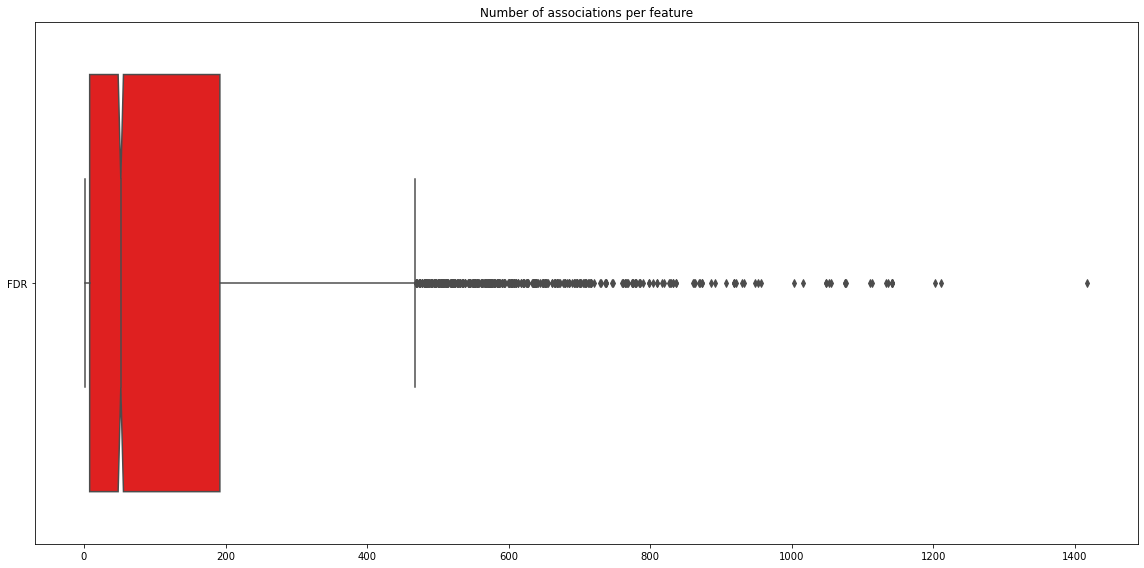

In [31]:
boxplot_neighbors(corr_pd)

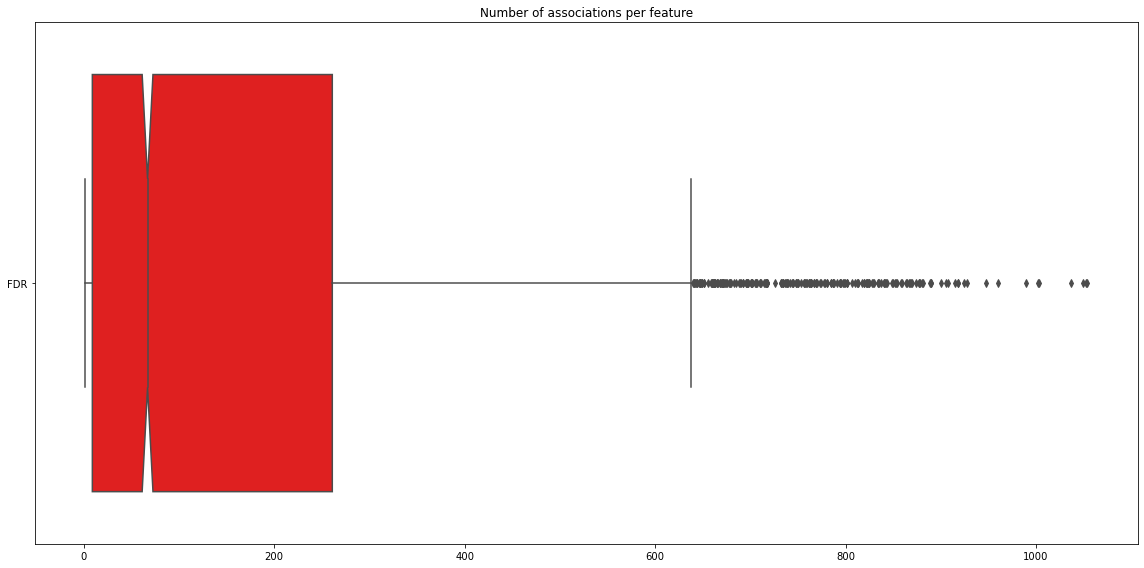

In [32]:
boxplot_neighbors(corr_ad)

# Network construction and preliminary analysis

We build 2 random networks to compare with those above.

In [33]:
### Generates each of the graphs
#positive associations, weighted
pd_w=ig.Graph.TupleList([tuple(x) for x in corr_pd.values], directed=False, edge_attrs=['w'])
ad_w=ig.Graph.TupleList([tuple(x) for x in corr_ad.values], directed=False, edge_attrs=['w'])

In [34]:
n_pd=len(np.unique([x for y in corr_pd[['feat1','feat2']].values for x in y]))
n_ad=len(np.unique([x for y in corr_ad[['feat1','feat2']].values for x in y]))

In [35]:
#random network, unweighted, node and edge number based on a network of the same size
random_pd=ig.Graph.Erdos_Renyi(n=n_pd, m=len(corr_pd.index.values), directed=False, loops=False)
random_ad=ig.Graph.Erdos_Renyi(n=n_ad, m=len(corr_ad.index.values), directed=False, loops=False)

In [36]:
#function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount=nn.vcount()
    ecount=nn.ecount()
    diameter=nn.diameter()
    av_path=nn.average_path_length()
    dens=nn.density()
    clustering=nn.transitivity_undirected() #this is the global clustering coefficient
    conn=nn.is_connected()
    min_cut=nn.mincut_value()
    out=pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','clustering_coef','connected?','minimum_cut']).T
    return(out)

#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [pd_w, ad_w, random_pd, random_ad]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index=['PD','AD','Random_PD','Random_AD']
network_stats

,node_count,edge_count,diameter,av_path_length,density,clustering_coef,connected?,minimum_cut
PD,5857,394405,18,3.598169,0.022998,0.39698,False,0.0
AD,4861,396985,11,3.004173,0.033608,0.442838,False,0.0
Random_PD,5857,394405,3,2.021067,0.022998,0.022961,True,89.0
Random_AD,4861,396985,3,1.970365,0.033608,0.033672,True,114.0


# Centrality analysis

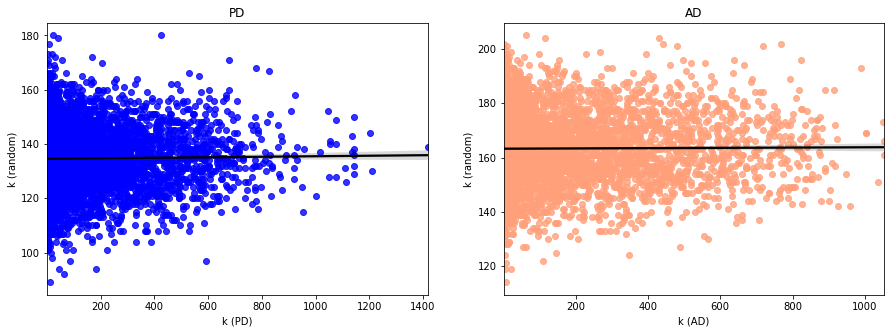

In [37]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for i, ax in zip(range(2), axes.flat):
    sns.regplot(x=[pd_w, ad_w][i].degree(), y=[random_pd, random_ad][i].degree(), 
                ax=ax, color=['blue','lightsalmon','green'][i],
               line_kws={'color':'black'}
               );
    ax.set_title(['PD','AD'][i])
    ax.set(xlabel='k ('+['PD','AD'][i]+')', ylabel='k (random)')

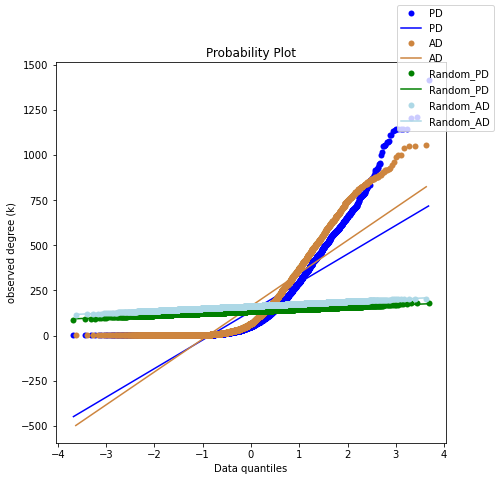

In [39]:
def transform_degree(graph):
    alldegs=graph.degree()
    alldegs=pd.DataFrame([[key,len(list(group))] for key,group in itertools.groupby(alldegs)], columns=['k','count'])
    alldegs['P(k)']=[x/alldegs['count'].sum() for x in alldegs['count']]
    alldegs=alldegs.loc[:,['k','P(k)']]
    alldegs.drop_duplicates(inplace=True)
    alldegs.reset_index(drop=True, inplace=True)
    return(alldegs)


fig, ax = plt.subplots(figsize=(7, 7))
p=sp.stats.probplot(pd_w.degree(), plot=ax)
a=sp.stats.probplot(ad_w.degree(), plot=ax)
k=sp.stats.probplot(random_pd.degree(), plot=ax)
r=sp.stats.probplot(random_ad.degree(), plot=ax)

col=['blue','','peru','','green','','lightblue','']
for x in np.arange(0,7,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])


fig.legend(labels=['PD','PD','AD','AD','Random_PD','Random_PD','Random_AD','Random_AD']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
plt.show()

**Centrality**  
We will now compare different centrality metrics between the graphs.

In [ ]:
centralities_list=['degree (larger ~ central)','eccentricity (smaller ~ central)','betweenness (larger ~ central)', 'closeness (larger ~ central)','eigenvector (larger ~ central)']

def combine_raw_centralities():
    """
    Combines centrality metrics
    """
    def centrality_raw(input_graph, graph_name):
        """
        Computes centrality metrics for a graph.
        """
        deg=input_graph.degree(loops=False)
        node_n=input_graph.vcount()
        #scaled to account for network size
        ecc=[(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.eccentricity()]
        btw=[(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.betweenness(directed=False)] 
        eig=input_graph.eigenvector_centrality(directed=False, scale=False)
        
        # For disconnected graphs, computes closeness from the largest connected component
        if(input_graph.is_connected()):
            cls=input_graph.closeness(normalized=True)
        else:
            cls=input_graph.clusters(mode='WEAK').giant().closeness(normalized=True)
        
        out=pd.DataFrame([deg, ecc, btw, cls,eig], index=centralities_list).T
        out['graph']=graph_name
        out=out.loc[:,np.append(['graph'],out.columns[out.columns!='graph'])]
        
        ##Adds centralities for each node in the network
        input_graph.vs['degree']=out['degree (larger ~ central)']
        input_graph.vs['eccentricity']=out['eccentricity (smaller ~ central)']
        input_graph.vs['betweenness']=out['betweenness (larger ~ central)']
        input_graph.vs['closeness']=out['closeness (larger ~ central)']
        input_graph.vs['eigenvector']=out['eigenvector (larger ~ central)']
        
        return(out)
    
    #Computes centralities for all networks
    network_centralities_raw=pd.DataFrame()
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(pd_w,'PD')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(ad_w,'AD')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(random_pd,'Random_PD')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(random_ad,'Random_AD')])
    return(network_centralities_raw)

network_centralities_raw=combine_raw_centralities()

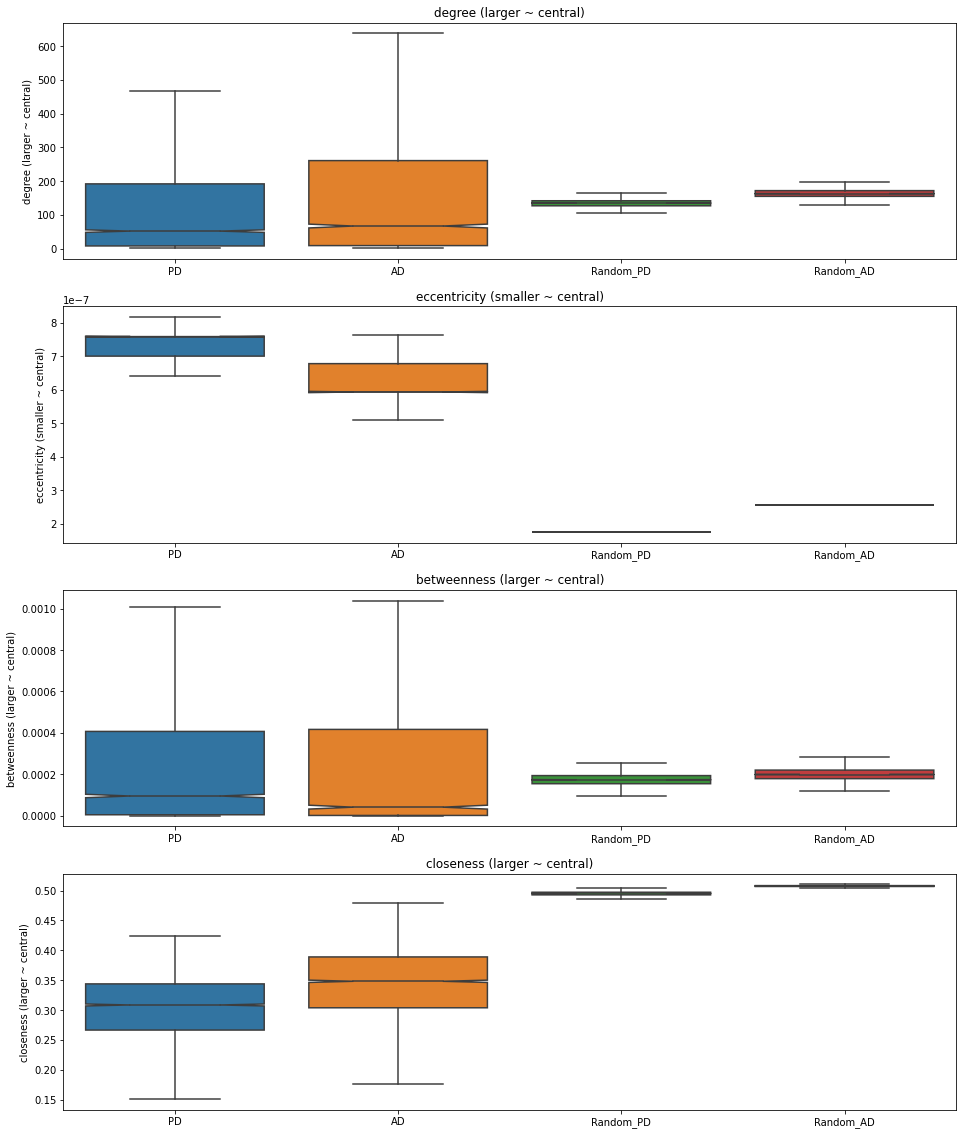

In [42]:

fig, axes=plt.subplots(nrows=4, figsize=(16,20), sharey='row')
for i, ax in zip(range(4), axes.flat):
    sns.boxplot(
        data=network_centralities_raw, x='graph', y=centralities_list[i],  notch=True, ax=ax, showfliers=False)
    ax.set_title(centralities_list[i])
    ax.set(xlabel='')

In [41]:
network_stats

,node_count,edge_count,diameter,av_path_length,density,clustering_coef,connected?,minimum_cut
PD,5857,394405,18,3.598169,0.022998,0.39698,False,0.0
AD,4861,396985,11,3.004173,0.033608,0.442838,False,0.0
Random_PD,5857,394405,3,2.021067,0.022998,0.022961,True,89.0
Random_AD,4861,396985,3,1.970365,0.033608,0.033672,True,114.0


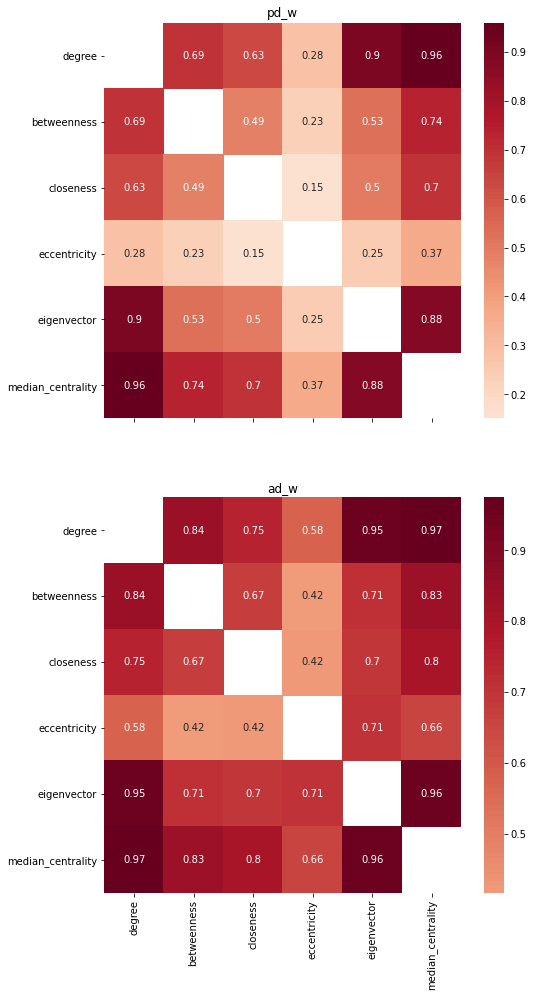

In [49]:
### Compute centrality ranks so that we can compare them within and between networks
full_centralities=pd.DataFrame()
for net in [0,1]:
    net_in=[pd_w, ad_w][net]
    net_nm=['pd_w', 'ad_w'][net]
    temp=pd.DataFrame([net_in.vs[att] for att in ['name','degree','betweenness', 'closeness','eccentricity','eigenvector']], index=['name','degree','betweenness', 'closeness','eccentricity','eigenvector']).T
    temp.columns=[x+'|'+net_nm for x in temp.columns]
    temp.rename(columns={'name|'+net_nm:'name'}, inplace=True)
    
    ## For all but eccentricity centrality, we compute the rank in ascending mode
    ## so that higher ranking means more central. we need to reverse this for eccentricity
    temp.loc[:,temp.columns.str.contains('deg|bet|clos|eig')]=temp.loc[:,temp.columns.str.contains('deg|bet|clos|eig')].rank(pct=True, ascending=True)
    temp.loc[:,temp.columns.str.contains('eccentricity')]=temp.loc[:,temp.columns.str.contains('eccentricity')].rank(pct=True, ascending=False
                                                              )
    temp['median_centrality|'+net_nm]=temp.loc[:,temp.columns!='name'].median(1)
    if(net==0):
        full_centralities=temp
    else:
        full_centralities=pd.merge(full_centralities, temp, on='name')
full_centralities.set_index('name', inplace=True)
full_centralities['median|ALL']=full_centralities.loc[:,full_centralities.columns.str.contains('median')].median(1)


### Correlations are computed between ranks, after inverting the rank for eccentricity
def correlations_centralities(graph_name):
    """
    Returns squared correlation matrix.
    """
    temp_corr=full_centralities.copy().loc[:,full_centralities.columns!='Type'].dropna().astype('float')
    temp_corr=temp_corr.loc[:,temp_corr.columns.str.contains(graph_name)]
    temp_corr.columns=temp_corr.columns.str.replace('\|.+','', regex=True)
    temp_corr=temp_corr.corr(method='spearman')
    np.fill_diagonal(temp_corr.values, np.nan)
    return(temp_corr)

pd_centcorr=correlations_centralities('pd_w')
ad_centcorr=correlations_centralities('ad_w')

fig,ax=plt.subplots(nrows=2, figsize=(8,16), sharex=True)
ax=ax.flatten()
for i in range(2):
    tdata=[pd_centcorr,ad_centcorr][i]
    tname=['pd_w','ad_w'][i]
    sns.heatmap(tdata, cmap="RdBu_r", center=0, annot=True, ax=ax[i]);
    ax[i].set(title=tname)

# Community analysis

Modularity optimization leads to very large communities. We instead use CPM, and scan resolution to find the value that leads to highest modularity.

In [207]:
comm_res=pd.DataFrame()
j=1
for res in np.geomspace(0.001,10,200):
    if(j%10==0):
        print(j)
    j+=1
    pd_comm = leidenalg.find_partition(pd_w, leidenalg.CPMVertexPartition, resolution_parameter=res)
    ad_comm = leidenalg.find_partition(ad_w, leidenalg.CPMVertexPartition, resolution_parameter=res)
    
    comm_counts=pd.DataFrame()
    for i in [0,1]:
        graph=[pd_w,ad_w][i]
        comm=[pd_comm,ad_comm][i]
        name=['PD','AD'][i]
        temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'feat',1:'community'})
        counts=pd.DataFrame(temp.groupby('community')['feat'].agg(len))
        counts.columns=[name]
        comm_counts=pd.concat([comm_counts, counts],1)
        
    comm_counts.index=['c'+str(i) for i in comm_counts.index]
    
    ### min, max and number of comms
    pd_df=comm_counts['PD']
    ad_df=comm_counts['AD']
    
    out=pd.DataFrame([
        pd.Series([res,pd_df.shape[0],pd_df.min(),pd_df.max(), pd_comm.modularity],name='PD'),
        pd.Series([res,ad_df.shape[0],ad_df.min(),ad_df.max(), ad_comm.modularity],name='AD'),
    ])
    out=out.T
    out.index=index=['res','comm_num','min_comm_size','max_comm_size','CPM modularity']
    comm_res=pd.concat([comm_res, out],1)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


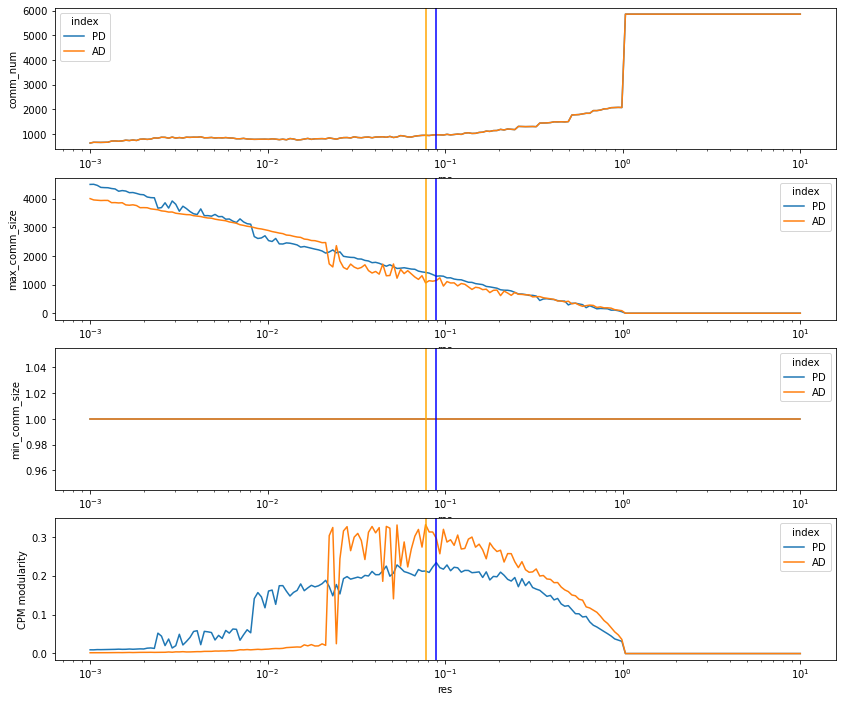

In [208]:
max_cpm_ad=comm_res.T.reset_index().loc[(comm_res.T.reset_index()['index']=='AD')].sort_values('CPM modularity', ascending=False).iloc[0]
max_cpm_pd=comm_res.T.reset_index().loc[(comm_res.T.reset_index()['index']=='PD')].sort_values('CPM modularity', ascending=False).iloc[0]

fig,ax=plt.subplots(figsize=(14,12), nrows=4);
ax=ax.flatten()
sb.lineplot(
    data=comm_res.T[['res','comm_num']].reset_index(),
    x='res', y='comm_num', hue='index', ax=ax[0])
ax[0].set(xscale="log");

sb.lineplot(
    data=comm_res.T[['res','max_comm_size']].reset_index(),
    x='res', y='max_comm_size', hue='index', ax=ax[1])
ax[1].set(xscale="log");

sb.lineplot(
    data=comm_res.T[['res','min_comm_size']].reset_index(),
    x='res', y='min_comm_size', hue='index', ax=ax[2])
ax[2].set(xscale="log");

sb.lineplot(
    data=comm_res.T[['res','CPM modularity']].reset_index(),
    x='res', y='CPM modularity', hue='index', ax=ax[3])
ax[3].set(xscale="log");

for j in range(4):
    ax[j].axvline(max_cpm_pd['res'], c='blue');
    ax[j].axvline(max_cpm_ad['res'], c='orange');

In [209]:
max_cpm_ad

index                   AD
res               0.077526
comm_num             957.0
min_comm_size          1.0
max_comm_size       1059.0
CPM modularity    0.332254
Name: 189, dtype: object

In [210]:
max_cpm_pd

index                   PD
res               0.089074
comm_num             981.0
min_comm_size          1.0
max_comm_size       1292.0
CPM modularity    0.234337
Name: 194, dtype: object

We will consider resolutions of 0.0775 and 0.0891 for community detection.

In [213]:
# pd_comm = leidenalg.find_partition(pd_w, leidenalg.ModularityVertexPartition, weights='w')
# ad_comm = leidenalg.find_partition(ad_w, leidenalg.ModularityVertexPartition, weights='w')
# random_ad_comm = leidenalg.find_partition(random_pd, leidenalg.ModularityVertexPartition)
# random_pd_comm = leidenalg.find_partition(random_ad, leidenalg.ModularityVertexPartition)
pd_comm = leidenalg.find_partition(pd_w, leidenalg.CPMVertexPartition, resolution_parameter=0.0891)
ad_comm = leidenalg.find_partition(ad_w, leidenalg.CPMVertexPartition, resolution_parameter=0.0775)
random_ad_comm = leidenalg.find_partition(random_pd, leidenalg.CPMVertexPartition)
random_pd_comm = leidenalg.find_partition(random_ad, leidenalg.CPMVertexPartition)

In [217]:
np.round(pd_comm.modularity,3)

0.216

In [218]:
np.round(ad_comm.modularity,3)

0.302

In [219]:
np.round(random_ad_comm.modularity,3)

-0.0

In [220]:
np.round(random_pd_comm.modularity,3)

-0.0

Comparing the different communities by size (we do not show communities with <30 elements):

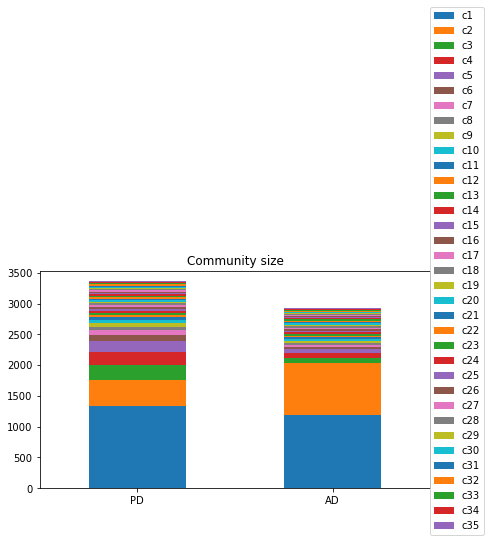

In [222]:
#Compiles feat lists per community
def get_community_table():
    comm_counts=pd.DataFrame()
    feat_lists=pd.DataFrame()
    for i in [0,1]:
        graph=[pd_w,ad_w][i]
        comm=[pd_comm,ad_comm][i]
        name=['PD','AD'][i]
        temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'feat',1:'community'})
        counts=pd.DataFrame(temp.groupby('community')['feat'].agg(len))
        counts.columns=[name]
        comm_counts=pd.concat([comm_counts, counts],1)
        
        gl=pd.DataFrame(temp.groupby('community')['feat'].apply(list)).reset_index()
        gl['community']=['c'+str(i) for i in gl['community']]
        gl['network']=name
        gl=gl.loc[:,['network','community','feat']]
        feat_lists=pd.concat([feat_lists, gl])
        
    comm_counts.index=['c'+str(i) for i in comm_counts.index]
    return([comm_counts,feat_lists])

#Plotting community sizes
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 4))
bar_data=get_community_table()[0].loc[get_community_table()[0].sum(1)>30].fillna(0).T
bar_data.plot(kind='bar', stacked=True, ax=ax);
# ## number of communities in each
# for index, row in groupedvalues.iterrows():
#     g.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")
ax.legend(get_community_table()[0].index, loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

In [272]:
get_community_table()[1].to_csv('../data/community_elements.tsv', sep="\t", index=False)

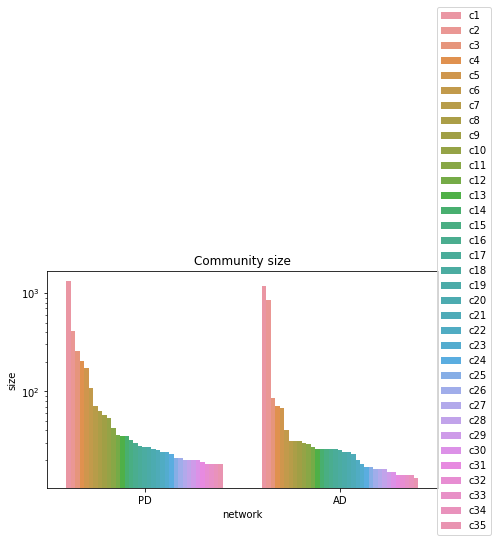

In [223]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=bar_data.T.unstack().reset_index().rename(columns={'level_0':'network','level_1':'community',0:'size'}),
    x='network',y='size', hue='community'
           )

ax.set(yscale='log');
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

**Functional analysis**  
We will use GO BP, KEGG and OMIM Diseases.

In [248]:
get_community_table()[0]['PD']>

c1      1337.0
c2       413.0
c3       257.0
c4       204.0
c5       174.0
         ...  
c931       NaN
c932       NaN
c933       NaN
c934       NaN
c935       NaN
Name: PD, Length: 935, dtype: float64

In [258]:

#we will search 3 libraries for significantly enriched gene sets
gene_sets=['GO_Biological_Process_2018','KEGG_2019_Human','OMIM_Disease']
background_pd=[x for x in pd_w.copy().vs['name']]
background_ad=[x for x in ad_w.copy().vs['name']]
all_genes=pro_data['Gene'].unique()

def perform_enrich(network):
    if(network=='PD'):
        background=background_pd
    else:
        background=background_ad
    temp=get_community_table()[1].copy()
    temp=temp.loc[temp['network']==network]
    
    ## ignoring comms <30 genes
    temp_size=get_community_table()[0][network]
    temp_size=temp_size.where(temp_size>30).dropna()
    temp=temp.loc[temp.community.isin(temp_size.index)]
    
    output_enrichr=pd.DataFrame()
    for comm in temp['community'].values:
        gl=list(temp.loc[temp['community']==comm, 'feat'])[0]
        gl=list([x for x in gl if x in all_genes])
        
        if(len(gl)<30):
            continue
        print('Found '+str(len(gl))+' genes in community '+comm)
        for bp in gene_sets:
            print('Analyzing '+network+' network | Comm: '+comm+'/'+str(len(temp.index))+'  | BP: '+bp)
            enr=gp.enrichr(
                gene_list=gl,
                gene_sets=bp,
                background=background,
                outdir='Enrichr',
                format='png'
            )

            results=enr.results.sort_values('Adjusted P-value', ascending=True)
            results=results.loc[results['Adjusted P-value']<0.05,]
            results['BP']=bp
            results['Comm']=comm
            results['Graph']=network
            output_enrichr=pd.concat([output_enrichr, results])
            
    return(output_enrichr)

all_enriched=pd.DataFrame()
for net in ['PD', 'AD']: 
    all_enriched=pd.concat([all_enriched,perform_enrich(net)])

Found 1337 genes in community c1
Analyzing PD network | Comm: c1/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c1/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c1/15  | BP: OMIM_Disease


2021-03-05 13:09:23,791 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 413 genes in community c2
Analyzing PD network | Comm: c2/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c2/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c2/15  | BP: OMIM_Disease


2021-03-05 13:09:38,101 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 257 genes in community c3
Analyzing PD network | Comm: c3/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c3/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c3/15  | BP: OMIM_Disease


2021-03-05 13:09:51,167 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 204 genes in community c4
Analyzing PD network | Comm: c4/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c4/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c4/15  | BP: OMIM_Disease


2021-03-05 13:10:03,893 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 174 genes in community c5
Analyzing PD network | Comm: c5/15  | BP: GO_Biological_Process_2018


2021-03-05 13:10:08,237 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing PD network | Comm: c5/15  | BP: KEGG_2019_Human


2021-03-05 13:10:11,920 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing PD network | Comm: c5/15  | BP: OMIM_Disease


2021-03-05 13:10:15,563 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 107 genes in community c6
Analyzing PD network | Comm: c6/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c6/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c6/15  | BP: OMIM_Disease


2021-03-05 13:10:27,428 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 71 genes in community c7
Analyzing PD network | Comm: c7/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c7/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c7/15  | BP: OMIM_Disease
Found 63 genes in community c8
Analyzing PD network | Comm: c8/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c8/15  | BP: KEGG_2019_Human


2021-03-05 13:10:47,125 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing PD network | Comm: c8/15  | BP: OMIM_Disease


2021-03-05 13:10:50,551 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 57 genes in community c9
Analyzing PD network | Comm: c9/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c9/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c9/15  | BP: OMIM_Disease


2021-03-05 13:11:04,266 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 53 genes in community c10
Analyzing PD network | Comm: c10/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c10/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c10/15  | BP: OMIM_Disease


2021-03-05 13:11:16,837 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 42 genes in community c11
Analyzing PD network | Comm: c11/15  | BP: GO_Biological_Process_2018


2021-03-05 13:11:21,038 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing PD network | Comm: c11/15  | BP: KEGG_2019_Human


2021-03-05 13:11:25,769 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing PD network | Comm: c11/15  | BP: OMIM_Disease


2021-03-05 13:11:29,230 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 36 genes in community c12
Analyzing PD network | Comm: c12/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c12/15  | BP: KEGG_2019_Human


2021-03-05 13:11:36,815 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing PD network | Comm: c12/15  | BP: OMIM_Disease
Found 35 genes in community c13
Analyzing PD network | Comm: c13/15  | BP: GO_Biological_Process_2018


2021-03-05 13:11:44,206 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing PD network | Comm: c13/15  | BP: KEGG_2019_Human


2021-03-05 13:11:47,638 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing PD network | Comm: c13/15  | BP: OMIM_Disease
Found 35 genes in community c14
Analyzing PD network | Comm: c14/15  | BP: GO_Biological_Process_2018
Analyzing PD network | Comm: c14/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c14/15  | BP: OMIM_Disease


2021-03-05 13:12:02,745 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 32 genes in community c15
Analyzing PD network | Comm: c15/15  | BP: GO_Biological_Process_2018


2021-03-05 13:12:06,419 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing PD network | Comm: c15/15  | BP: KEGG_2019_Human
Analyzing PD network | Comm: c15/15  | BP: OMIM_Disease


2021-03-05 13:12:13,532 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 1188 genes in community c1
Analyzing AD network | Comm: c1/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c1/9  | BP: KEGG_2019_Human
Analyzing AD network | Comm: c1/9  | BP: OMIM_Disease
Found 846 genes in community c2
Analyzing AD network | Comm: c2/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c2/9  | BP: KEGG_2019_Human
Analyzing AD network | Comm: c2/9  | BP: OMIM_Disease


2021-03-05 13:12:51,248 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 86 genes in community c3
Analyzing AD network | Comm: c3/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c3/9  | BP: KEGG_2019_Human


2021-03-05 13:12:59,262 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing AD network | Comm: c3/9  | BP: OMIM_Disease


2021-03-05 13:13:02,709 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 71 genes in community c4
Analyzing AD network | Comm: c4/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c4/9  | BP: KEGG_2019_Human


2021-03-05 13:13:10,636 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing AD network | Comm: c4/9  | BP: OMIM_Disease
Found 68 genes in community c5
Analyzing AD network | Comm: c5/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c5/9  | BP: KEGG_2019_Human
Analyzing AD network | Comm: c5/9  | BP: OMIM_Disease
Found 40 genes in community c6
Analyzing AD network | Comm: c6/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c6/9  | BP: KEGG_2019_Human
Analyzing AD network | Comm: c6/9  | BP: OMIM_Disease


2021-03-05 13:13:37,966 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 31 genes in community c7
Analyzing AD network | Comm: c7/9  | BP: GO_Biological_Process_2018


2021-03-05 13:13:41,569 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing AD network | Comm: c7/9  | BP: KEGG_2019_Human


2021-03-05 13:13:45,024 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing AD network | Comm: c7/9  | BP: OMIM_Disease


2021-03-05 13:13:48,587 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 31 genes in community c8
Analyzing AD network | Comm: c8/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c8/9  | BP: KEGG_2019_Human


2021-03-05 13:13:56,340 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing AD network | Comm: c8/9  | BP: OMIM_Disease
Found 31 genes in community c9
Analyzing AD network | Comm: c9/9  | BP: GO_Biological_Process_2018
Analyzing AD network | Comm: c9/9  | BP: KEGG_2019_Human


2021-03-05 13:14:08,305 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing AD network | Comm: c9/9  | BP: OMIM_Disease


2021-03-05 13:14:11,689 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


In [259]:
enriched_terms=all_enriched.loc[:,['Graph','Comm','Term','Adjusted P-value']].copy()

In [260]:
enriched_terms['Adjusted P-value']=-1*np.log10(enriched_terms['Adjusted P-value'])

In [261]:
enriched_terms.head()

,Graph,Comm,Term,Adjusted P-value
0,PD,c1,flavonoid glucuronidation (GO:0052696),7.028965
1,PD,c1,xenobiotic glucuronidation (GO:0052697),5.643128
2,PD,c1,cellular glucuronidation (GO:0052695),3.333943
3,PD,c1,coumarin metabolic process (GO:0009804),2.170088
4,PD,c1,glucuronate metabolic process (GO:0019585),2.019711


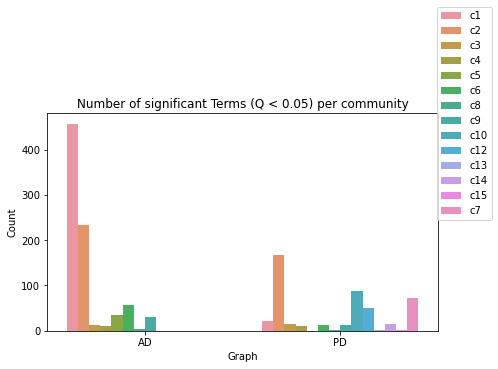

In [262]:
fig, ax = plt.subplots(figsize=(7, 4))
data_bars=pd.DataFrame(enriched_terms.groupby(['Graph','Comm'])['Term'].agg('count')).stack().reset_index().rename(columns={0:'Count'})
sns.barplot(x='Graph', y='Count', data=data_bars, hue='Comm')
ax.set_title('Number of significant Terms (Q < 0.05) per community')
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
plt.xticks(rotation=0)
plt.show()

Note that some of these communities are very big, which explains the big number of biological processes found above.

In [263]:
###Number of genes/community
# We skipped communities with <30 genes
get_community_table()[0].fillna(0).T

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c926,c927,c928,c929,c930,c931,c932,c933,c934,c935
PD,1337.0,413.0,257.0,204.0,174.0,107.0,71.0,63.0,57.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AD,1188.0,846.0,86.0,71.0,68.0,40.0,31.0,31.0,31.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [264]:
pd.DataFrame(enriched_terms.groupby(['Graph','Comm'])['Term'].agg('count'))

Term
Graph Comm      
AD    c1     457
      c2     233
      c3      12
      c4      10
      c5      35
      c6      58
      c8       5
      c9      30
PD    c1      21
      c10     87
      c12     50
      c13      2
      c14     14
      c15      2
      c2     168
      c3      14
      c4      11
      c6      12
      c7      72
      c8       1
      c9      13

In [270]:
all_enriched.to_csv('../data/enrichment_results.tsv',sep="\t", index=False)